# Group Colab

In [ ]:
# Import nessecary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Read in data
df = pd.read_csv("./data.csv")

In [ ]:
# Map non numerical values in training parameters to integers 0 - # of types
maps = []
for feat in ["protocol_type", "service", "flag", "class"]:
  map = {}
  for i in range(len(list(df[feat].unique()))):
    val = list(df[feat].unique())[i]
    map[val] = i
  df[feat].replace(map, inplace=True)
  print(map)

# Convert all values to floats except null values which are replaced by zeros
for feat in list(df.columns):
  for val in list(df[feat].unique()):
    map = {}
    try:
      if type(val) != int:
        map = {val: int(val)}
        map = {val: float(val)}
    except :
      map = {val: 0.0}
    df[feat].replace(map, inplace=True)

df["same_srv_rate"].fillna(0)


{'tcp': 0, 'udp': 1, 'icmp': 2}
{'http': 0, 'smtp': 1, 'finger': 2, 'domain_u': 3, 'auth': 4, 'telnet': 5, 'ftp': 6, 'eco_i': 7, 'ntp_u': 8, 'ecr_i': 9, 'other': 10, 'private': 11, 'pop_3': 12, 'ftp_data': 13, 'rje': 14, 'time': 15, 'mtp': 16, 'link': 17, 'remote_job': 18, 'gopher': 19, 'ssh': 20, 'name': 21, 'whois': 22, 'domain': 23, 'login': 24, 'imap4': 25, 'daytime': 26, 'ctf': 27, 'nntp': 28, 'shell': 29, 'IRC': 30, 'nnsp': 31, 'http_443': 32, 'exec': 33, 'printer': 34, 'efs': 35, 'courier': 36, 'uucp': 37, 'klogin': 38, 'kshell': 39, 'echo': 40, 'discard': 41, 'systat': 42, 'supdup': 43, 'iso_tsap': 44, 'hostnames': 45, 'csnet_ns': 46, 'pop_2': 47, 'sunrpc': 48, 'uucp_path': 49, 'netbios_ns': 50, 'netbios_ssn': 51, 'netbios_dgm': 52, 'sql_net': 53, 'vmnet': 54, 'bgp': 55, 'Z39_50': 56, 'ldap': 57, 'netstat': 58, 'urh_i': 59, 'X11': 60, 'urp_i': 61, 'pm_dump': 62, 'tftp_u': 63, 'tim_i': 64, 'red_i': 65}
{'SF': 0, 'S1': 1, 'REJ': 2, 'S2': 3, 'S0': 4, 'S3': 5, 'RSTO': 6, 'RSTR': 7,

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
494016    1.0
494017    1.0
494018    1.0
494019    1.0
494020    1.0
Name: same_srv_rate, Length: 494021, dtype: float64

## Forming Initial Training and Testing Data

In [ ]:
# First zip the columns of the dataset and split into data and labels
cols = [list(df[col]) for col in df.columns]
zipped = list(zip(*cols))
X = [row[:-1] for row in zipped]
y = [row[-1] for row in zipped]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Parameter Selection

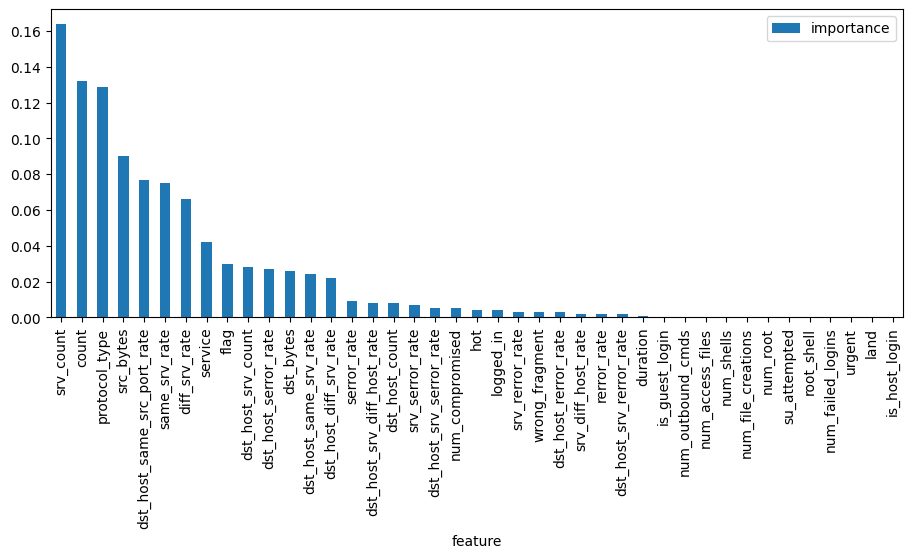

In [ ]:
# Use a random forest classifier to get rough importance and plot it
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier();

# fit random forest classifier on the training set
forest.fit(X_train, y_train);
# extract important features
score = np.round(forest.feature_importances_,3)
importances_dict = {'feature':list(df.columns[:-1]),'importance':score}
importances = pd.DataFrame({'feature':list(df.columns[:-1]),'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [ ]:
# Take all parameters above the 0.04 importance threshold
arr = []
for i in range(len(importances_dict["importance"])):
  if importances_dict["importance"][i]>0.04:
    arr.append([importances_dict['feature'][i], importances_dict["importance"][i]])

post_selected = []
for i in arr:
  post_selected.append(i[0])
print(post_selected)

['protocol_type', 'service', 'src_bytes', 'count', 'srv_count', 'same_srv_rate', 'diff_srv_rate', 'dst_host_same_src_port_rate']


In [ ]:
# Resplit training and testing data only including the selected parameters
cols = [list(df[col]) for col in post_selected + ["class"]]
zipped = list(zip(*cols))
X = [row[:-1] for row in zipped]
y = [row[-1] for row in zipped]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

## Model Creation and Training

In [ ]:
# Chose a decision tree classifier and fit to the post selected parameters and labels
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=67,min_samples_leaf=10,min_samples_split=5,max_depth=10,max_leaf_nodes=10)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)


0.9932239928343345

In [ ]:
# Print number of samples for each class of packet capture and key.
print("Attack Indices:\n{'normal': 0, 'buffer_overflow': 1, 'loadmodule': 2, 'perl': 3, 'neptune': 4, 'smurf': 5,\n 'guess_passwd': 6, 'pod': 7, 'teardrop': 8, 'portsweep': 9, 'ipsweep': 10, 'land': 11, 'ftp_write': 12, 'back': 13,\n 'imap': 14, 'satan': 15, 'phf': 16, 'nmap': 17, 'multihop': 18,\n 'warezmaster': 19, 'warezclient': 20, 'spy': 21, 'rootkit': 22}")
pd.Series(y_test).value_counts()

Attack Indices:
{'normal': 0, 'buffer_overflow': 1, 'loadmodule': 2, 'perl': 3, 'neptune': 4, 'smurf': 5,
 'guess_passwd': 6, 'pod': 7, 'teardrop': 8, 'portsweep': 9, 'ipsweep': 10, 'land': 11, 'ftp_write': 12, 'back': 13,
 'imap': 14, 'satan': 15, 'phf': 16, 'nmap': 17, 'multihop': 18,
 'warezmaster': 19, 'warezclient': 20, 'spy': 21, 'rootkit': 22}


5.0     112364
4.0      42797
0.0      38977
13.0       879
15.0       602
10.0       497
9.0        434
20.0       415
8.0        398
7.0         93
17.0        85
6.0         23
1.0         14
11.0         8
19.0         7
14.0         4
22.0         3
18.0         2
12.0         2
2.0          2
3.0          2
16.0         1
dtype: int64

## Assessing Accuracy

In [ ]:
# Print accuracy at prediction each class of network traffic
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     38977
         1.0       0.00      0.00      0.00        14
         2.0       0.00      0.00      0.00         2
         3.0       0.00      0.00      0.00         2
         4.0       1.00      1.00      1.00     42797
         5.0       1.00